In [5]:
# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Compsci 361 Assignment 3

## Task 1: Exploratory data analytics on text data


### a) 

In [6]:
data_X = pd.read_csv("train.csv")
data_y = pd.read_csv("test.csv")
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer()
tfid.fit(data_X["Text"])

tfidDF = tfid.transform(data_X["Text"])

#number of articles and features
num_articles = tfidDF.shape[0]
num_features = tfidDF.shape[1]

print(f"Number of articles: {num_articles}")
print(f"Number of extracted features: {num_features}")

#5 example articles
fivearticles = data_X["Text"].head(5)
features = tfidDF[:5].toarray()
feature_names = tfid.get_feature_names_out()

example_df = pd.DataFrame(features, columns=feature_names, index=fivearticles)

print(example_df.head())

Number of articles: 428
Number of extracted features: 13518
                                                     00       000  000th  \
Text                                                                       
lifestyle governs mobile choice faster better f...  0.0  0.020115    0.0   
french honour director parker british film dire...  0.0  0.000000    0.0   
fockers fuel festive film chart comedy meet foc...  0.0  0.000000    0.0   
housewives lift channel 4 ratings debut us tele...  0.0  0.000000    0.0   
u2 desire number one u2 three prestigious gramm...  0.0  0.000000    0.0   

                                                    001st  0051  007  0100  \
Text                                                                         
lifestyle governs mobile choice faster better f...    0.0   0.0  0.0   0.0   
french honour director parker british film dire...    0.0   0.0  0.0   0.0   
fockers fuel festive film chart comedy meet foc...    0.0   0.0  0.0   0.0   
housewives lift c

In [3]:
data_X["Category"].unique()

array(['tech', 'entertainment'], dtype=object)

For these articles, we peformed vectorisation using inverse document frequency as a way of tokenising the texts. From this, we observed 13518 unique words becoming our features from 428 articles.

### b)


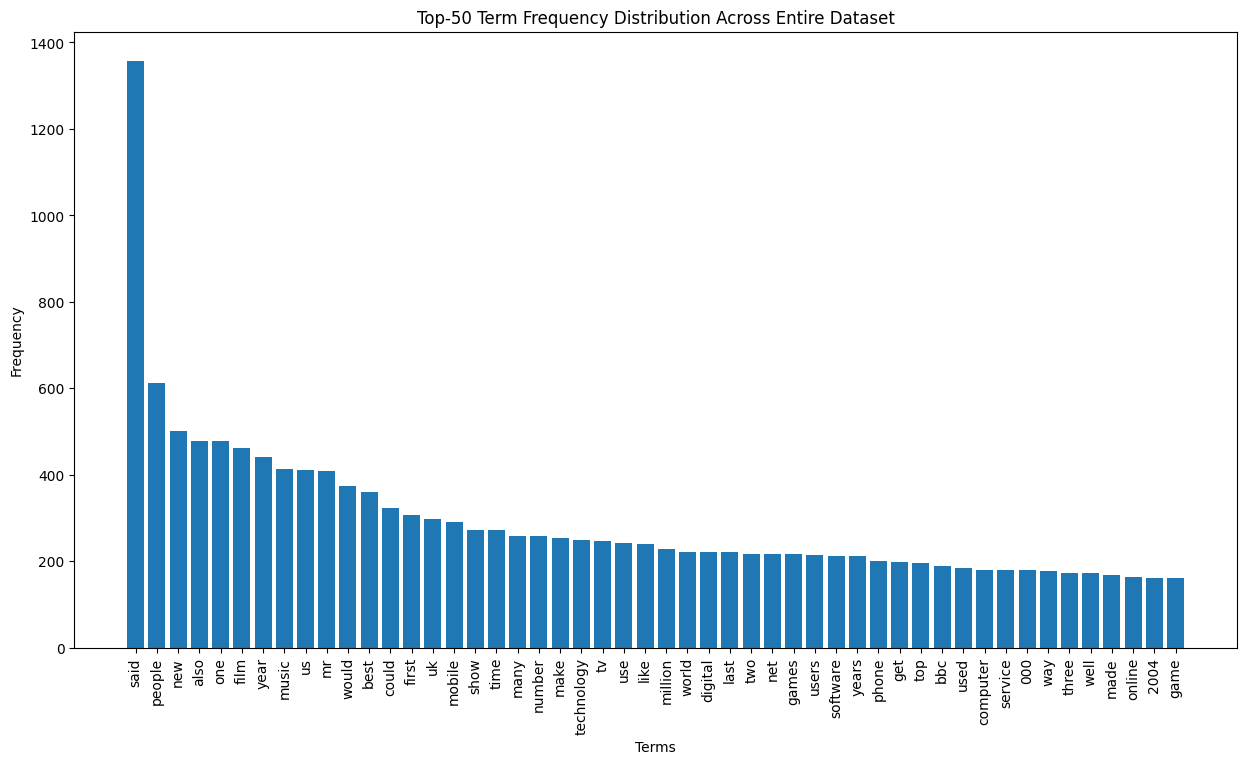

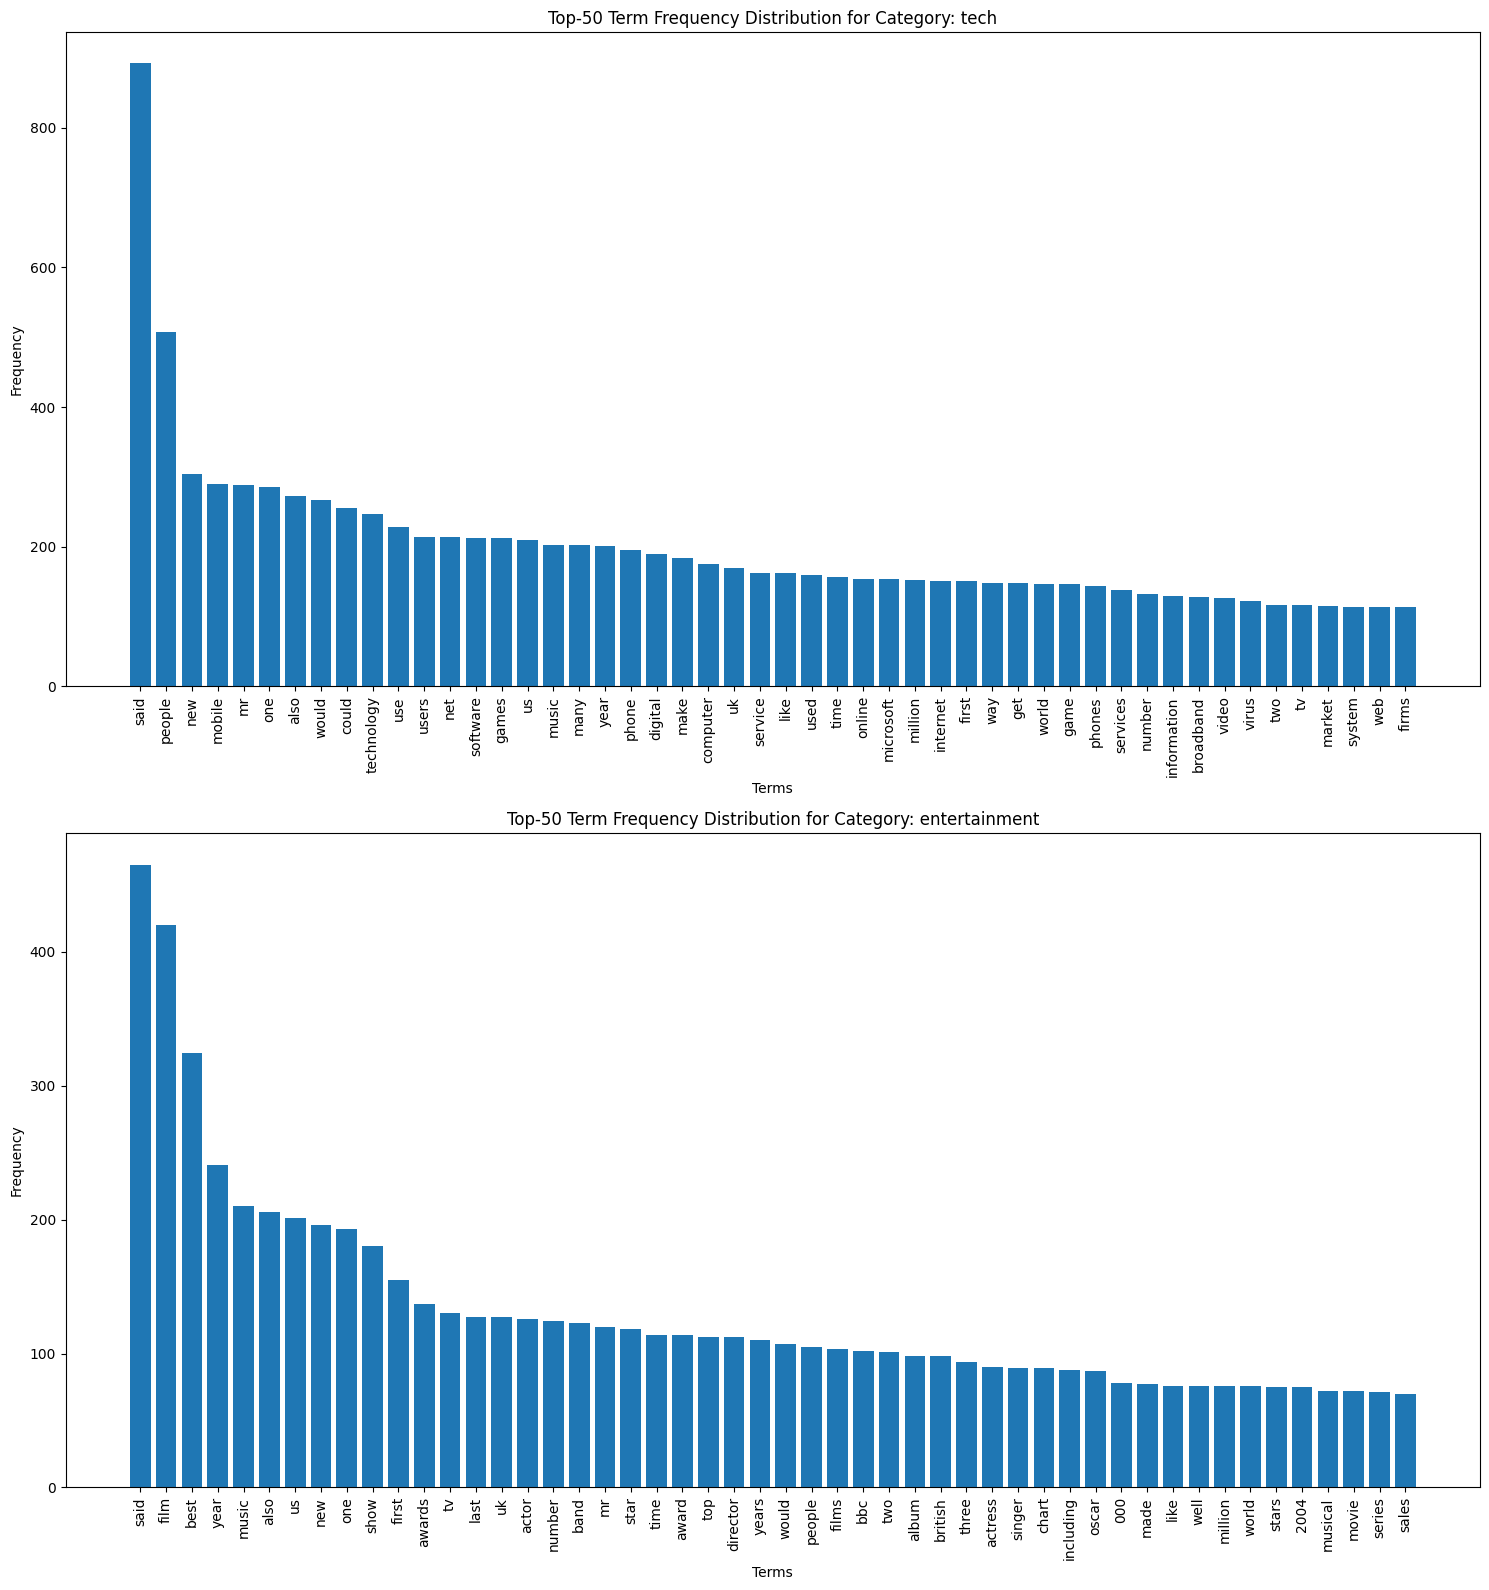

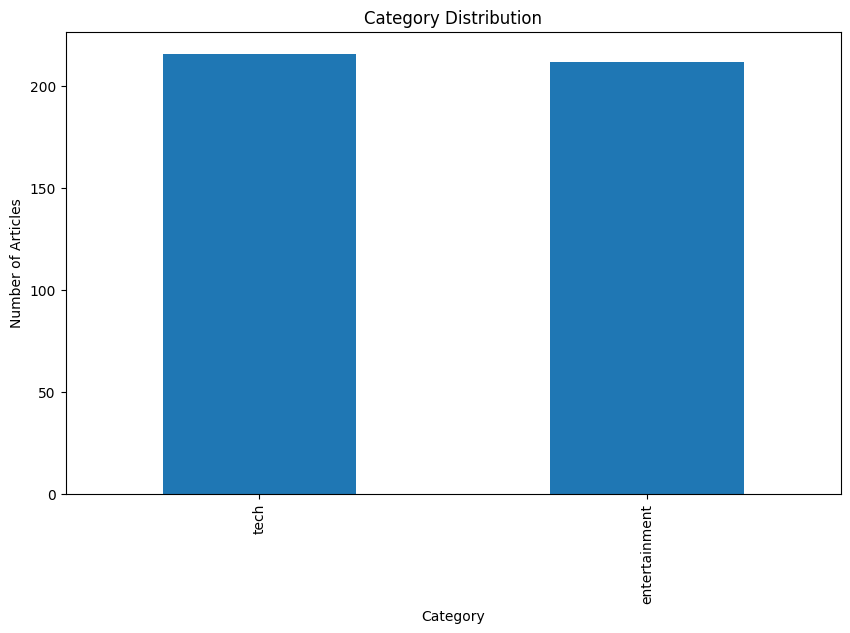

In [8]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

word_matrix = vectorizer.fit_transform(data_X["Text"])
word_hz = word_matrix.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

term_freq_df = pd.DataFrame({'term': terms, 'frequency': word_hz})
term_freq_df = term_freq_df.sort_values(by='frequency', ascending=False)

#plot 1
plt.figure(figsize=(15, 8))
top50 = term_freq_df.head(50)
plt.bar(top50['term'], top50['frequency'])
plt.xticks(rotation=90)
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.title('Top-50 Term Frequency Distribution Across Entire Dataset')
plt.show()

categories = data_X['Category'].unique()
term_hz = {}

for category in categories:
    category_texts = data_X[data_X['Category'] == category]['Text']
    category_word_matrix = vectorizer.transform(category_texts)
    category_word_hz = category_word_matrix.sum(axis=0).A1
    term_hz[category] = category_word_hz

#plot 2&3
fig, axes = plt.subplots(len(categories), 1, figsize=(15, 8 * len(categories)))

for i, category in enumerate(categories):
    term_freqDF = pd.DataFrame({'term': terms, 'frequency': term_hz[category]})
    term_freqDF = term_freqDF.sort_values(by='frequency', ascending=False)
    top50_terms = term_freqDF.head(50)
    
    axes[i].bar(top50_terms['term'], top50_terms['frequency'])
    axes[i].set_xticks(range(len(top50_terms['term'])))
    axes[i].set_xticklabels(top50_terms['term'], rotation=90)
    axes[i].set_xlabel('Terms')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Top-50 Term Frequency Distribution for Category: {category}')

plt.tight_layout()
plt.show()

#plot 4
plt.figure(figsize=(10, 6))
category_distribution = data_X['Category'].value_counts()
category_distribution.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Category Distribution')
plt.show()

From looking at the above plots, we notice "said' was mentioned the most frequently across all articles, surpassing the closest frequent word by over two times. The remaining top term frequencies seems quite consistent ranging from 600 down to 200. We also see "said" is most frequent in the category tech compared to entertainment. Overall, the data seems fairly balanced with similar number of articles for each category. 

## Task 2: Classification Models Learning

In [9]:
#Vectorizing after data split
X_train, X_test, y_train, y_test = train_test_split(data_X["Text"], data_X["Category"], test_size=0.2,random_state=42)

#Tfid Vectorizer
X_train_tfid = tfid.fit_transform(X_train)
X_test_tfid = tfid.transform(X_test)

#Count Vectorizer
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)


Helper functions

### a) Naive Bayes

In [7]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()

model.fit(X_train_count, y_train)
pred = model.predict(X_test_count)

print('Gaussian Naive Bayes')
print('Accuracy:', accuracy_score(y_test, pred))
print('Classification Report:')
print(classification_report(y_test, pred))


Gaussian Naive Bayes
Accuracy: 0.9767441860465116
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      0.97      0.97        38
         tech       0.98      0.98      0.98        48

     accuracy                           0.98        86
    macro avg       0.98      0.98      0.98        86
 weighted avg       0.98      0.98      0.98        86



### b) kNN

In [8]:
# finding the best 20 words:

log_probabilities = model.feature_log_prob_

words = vectorizer.get_feature_names_out()

change_log_probabilities = [abs(log_probabilities[0][i] - log_probabilities[1][i]) for i in range(len(log_probabilities[0]))]

value_order = np.argsort(change_log_probabilities)

best_20 = value_order[len(log_probabilities[0]) - 20:][::-1]

print(words[best_20])

['software' 'users' 'microsoft' 'singer' 'mobile' 'virus' 'oscar' 'band'
 'pc' 'firms' 'stars' 'broadband' 'rock' 'data' 'chart' 'album' 'actress'
 'nominations' 'gadget' 'festival']


In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# Define parameters for GridSearchCV
knn_param_grid = {
    "n_neighbors": range(1, 50),
    "metric": ["euclidean", "manhattan", "minkowski", "cosine"]
}

# use cross validation to find optimal parameters k and distance metric
grid_search = GridSearchCV(knn, knn_param_grid, cv = 5)
grid_search.fit(X_train_count, y_train)
best_params = grid_search.best_params_
best_k = best_params["n_neighbors"]
best_metric = best_params["metric"]

print(f'Best parameters: k = {best_k}, metric = {best_metric}')

#best_k 



Best parameters: k = 20, metric = cosine


In [10]:
#best_k = 20
# best_metric = cosine
# train a knn classifier with the optimal parameters 
knn_best = KNeighborsClassifier(n_neighbors = best_k, metric = best_metric)
knn_best.fit(X_train_count, y_train)

y_pred_knn = knn_best.predict(X_test_count)

print("K-Nearest Neighbor:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbor:
Accuracy: 0.9418604651162791
Classification Report:
               precision    recall  f1-score   support

entertainment       0.95      0.92      0.93        38
         tech       0.94      0.96      0.95        48

     accuracy                           0.94        86
    macro avg       0.94      0.94      0.94        86
 weighted avg       0.94      0.94      0.94        86



In [11]:
print(X_train_count.shape)
print(X_test_count.shape)
print()

(342, 12336)
(86, 12336)



In [ ]:
# Can't use standard scaler with tdfidf
std_scaler = StandardScaler(with_mean=False)
scaled_X_knn = std_scaler.fit_transform(X_train_tfid)


pca_trunc_scaled = TruncatedSVD(2)
pca_trunc_knn_scaled = pca_trunc_scaled.fit_transform(X_train_tfid)

plt.scatter(pca_trunc_knn_scaled[:,0], pca_trunc_knn_scaled[:,1])
# plt.scatter(components_knn[:,0], components_knn[:,1], c =ListedColormap(['lightblue', 'orange']))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [12]:


# pca_knn = PCA(n_components = 2).fit(scaled_X_knn.todense())
# pca_knn = PCA(n_components = 2).fit(scaled_X_knn)

# WIthout scaler
pca_knn = PCA(n_components = 2).fit(X_train_count)
components_knn = pca_knn.transform(X_train_count)

#With Scaler

std_scaler = StandardScaler(with_mean=False)
scaled_X_knn = std_scaler.fit_transform(X_train_count)

plt.scatter(components_knn[:,0], components_knn[:,1])
# plt.scatter(components_knn[:,0], components_knn[:,1], c =ListedColormap(['lightblue', 'orange']))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

TypeError: PCA only support sparse inputs with the "arpack" solver, while "auto" was passed. See TruncatedSVD for a possible alternative.

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

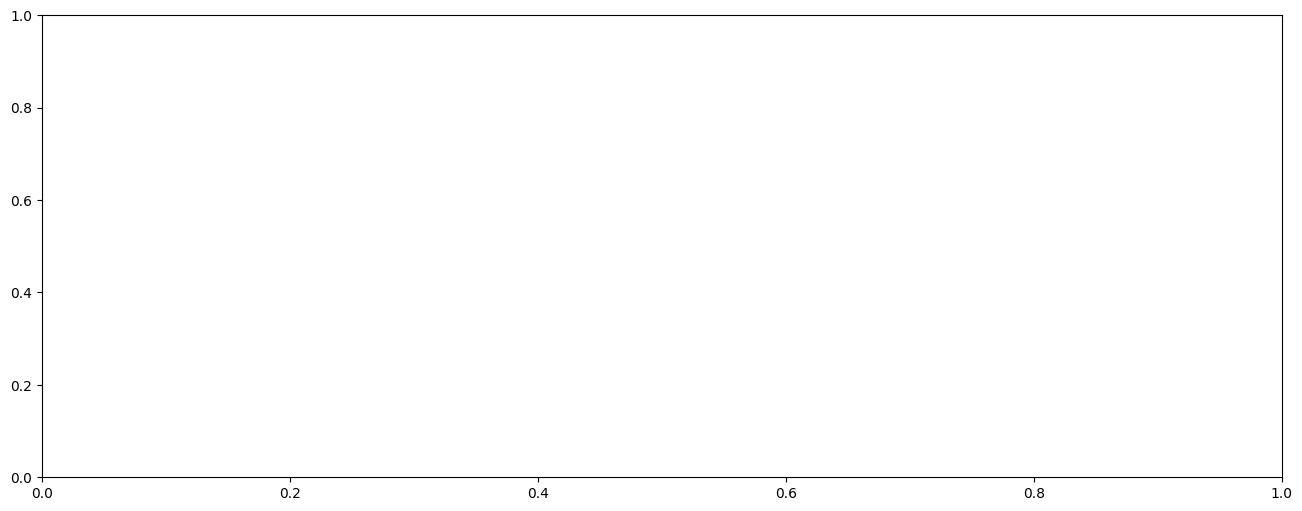

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
plot_decision_regions(pca_knn, components_knn, y_train, ax, knn_best)

## Standard PCS Memory Error
# MemoryError: Unable to allocate 350. GiB for an array with shape (3806130, 12336) and data type float64

In [ ]:

plt.scatter(pca_trunc_knn[:,0], pca_trunc_knn[:,1])
# plt.scatter(components_knn[:,0], components_knn[:,1], c =ListedColormap(['lightblue', 'orange']))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

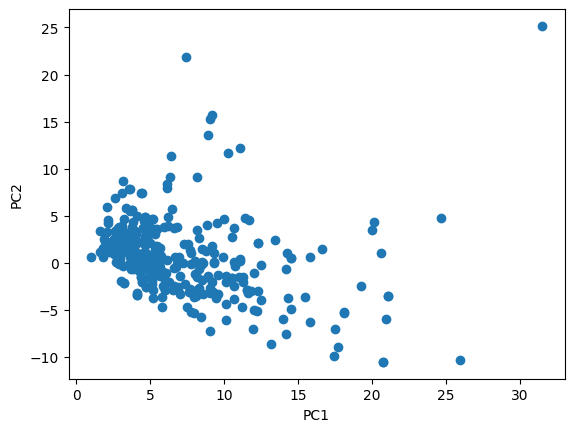

In [ ]:
from sklearn.decomposition import TruncatedSVD

pca_trunc = TruncatedSVD(2)
pca_trunc_knn = pca_trunc.fit_transform(X_train_count)

plt.scatter(pca_trunc_knn[:,0], pca_trunc_knn[:,1])
# plt.scatter(components_knn[:,0], components_knn[:,1], c =ListedColormap(['lightblue', 'orange']))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

MemoryError: Unable to allocate 282. GiB for an array with shape (3062864, 12336) and data type float64

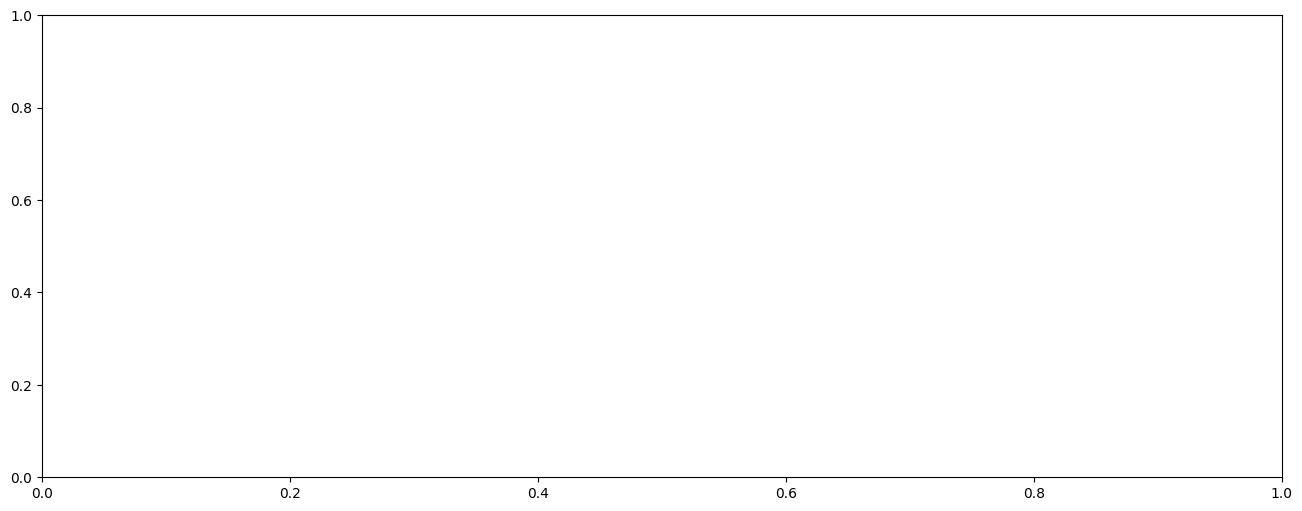

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
plot_decision_regions(pca_trunc, pca_trunc_knn, y_train, ax, knn_best)

In [ ]:
print(scaled_X_knn)

  (0, 33)	2.0744423969534918
  (0, 540)	2.347039648447215
  (0, 590)	6.189601711066001
  (0, 645)	13.998430930048933
  (0, 780)	2.545372894226728
  (0, 828)	3.5920485822297468
  (0, 884)	13.115101309290036
  (0, 915)	7.371905303478977
  (0, 973)	18.520338348726774
  (0, 1012)	3.0201398335631513
  (0, 1114)	8.665694308872268
  (0, 1118)	11.079601820929028
  (0, 1185)	3.5920485822297468
  (0, 1227)	3.7137610266396033
  (0, 1330)	1.6822000518642402
  (0, 1336)	9.301173814069202
  (0, 1393)	2.01117327129486
  (0, 1416)	4.2380776551760135
  (0, 1427)	3.665571695241831
  (0, 1431)	13.115101309290036
  (0, 1808)	18.520338348726774
  (0, 1840)	1.051372449010046
  (0, 1857)	3.5867110645337386
  (0, 1859)	3.1741591667261977
  (0, 1980)	4.532684743661388
  :	:
  (341, 11165)	2.1605794241998746
  (341, 11175)	1.2198968819579732
  (341, 11222)	2.6211706762982283
  (341, 11236)	8.331556684993041
  (341, 11237)	5.935496649980329
  (341, 11239)	12.379203422132003
  (341, 11281)	6.951500312306267
  (34

In [ ]:
print(np.unique(y_train))

['entertainment' 'tech']


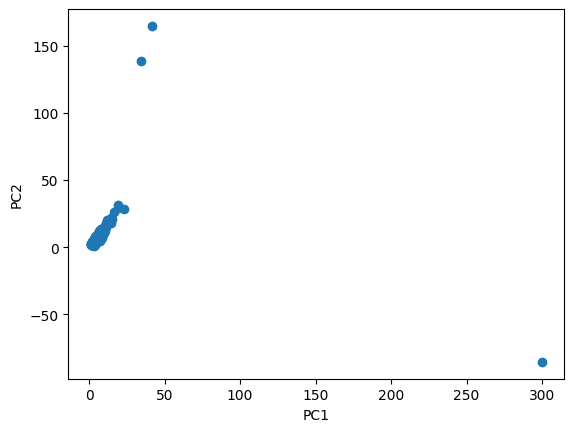

In [ ]:
std_scaler = StandardScaler(with_mean=False)
scaled_X_knn = std_scaler.fit_transform(X_train_count)


pca_trunc_scaled = TruncatedSVD(2)
pca_trunc_knn_scaled = pca_trunc.fit_transform(scaled_X_knn)

plt.scatter(pca_trunc_knn_scaled[:,0], pca_trunc_knn_scaled[:,1])
# plt.scatter(components_knn[:,0], components_knn[:,1], c =ListedColormap(['lightblue', 'orange']))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


### c) SVM

In [11]:
# soft SVM
from sklearn.svm import SVC

# use cross validation to choose C
c_param = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(kernel = "linear"), c_param, cv = 5)
grid_search.fit(X_train_count, y_train)
best_c = grid_search.best_params_['C']
print(f'Best C parameter: {best_c}')

# train final model with best c
linear_svm = SVC(kernel = "linear", C = best_c)
linear_svm.fit(X_train_count, y_train)

y_pred_linear = linear_svm.predict(X_test_count)
print('Soft-Margin Linear SVM:')
print('Accuracy:', accuracy_score(y_test, y_pred_linear))
print('Classification Report:')
print(classification_report(y_test, y_pred_linear))

Best C parameter: 0.01
Soft-Margin Linear SVM:
Accuracy: 0.9883720930232558
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      1.00      0.99        38
         tech       1.00      0.98      0.99        48

     accuracy                           0.99        86
    macro avg       0.99      0.99      0.99        86
 weighted avg       0.99      0.99      0.99        86



#### Hard-Margin RBF with varying kernel width


In [12]:
gamma_param = {'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(SVC(kernel = "rbf"), gamma_param, cv = 5)
grid_search.fit(X_train_count, y_train)
best_gamma = grid_search.best_params_['gamma']
print(f'Best gamma parameter: {best_gamma}')

# train final model with best c
rbf_svm = SVC(kernel = "rbf", gamma = best_gamma)
rbf_svm.fit(X_train_count, y_train)

y_pred_rbf = rbf_svm.predict(X_test_count)
print('Hard-Margin RBF SVM:')
print('Accuracy:', accuracy_score(y_test, y_pred_rbf))
print('Classification Report:')
print(classification_report(y_test, y_pred_rbf))


Best gamma parameter: 0.001
Hard-Margin RBF SVM:
Accuracy: 0.9767441860465116
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      0.97      0.97        38
         tech       0.98      0.98      0.98        48

     accuracy                           0.98        86
    macro avg       0.98      0.98      0.98        86
 weighted avg       0.98      0.98      0.98        86



In [13]:
gamma_param = {'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(SVC(kernel = "rbf"), gamma_param, cv = 5)
grid_search.fit(X_train_tfid, y_train)
best_gamma = grid_search.best_params_['gamma']
print(f'Best gamma parameter: {best_gamma}')

# train final model with best c
rbf_svm = SVC(kernel = "rbf", gamma = best_gamma)
rbf_svm.fit(X_train_tfid, y_train)

y_pred_rbf = rbf_svm.predict(X_test_tfid)
print('Hard-Margin RBF SVM:')
print('Accuracy:', accuracy_score(y_test, y_pred_rbf))
print('Classification Report:')
print(classification_report(y_test, y_pred_rbf))


Best gamma parameter: 1
Hard-Margin RBF SVM:
Accuracy: 0.9883720930232558
Classification Report:
               precision    recall  f1-score   support

entertainment       0.97      1.00      0.99        38
         tech       1.00      0.98      0.99        48

     accuracy                           0.99        86
    macro avg       0.99      0.99      0.99        86
 weighted avg       0.99      0.99      0.99        86



In [16]:
y_train_rbf = rbf_svm.predict(X_train_tfid)

In [ ]:
plot_graph_pca(X_train, y_train)

ValueError: could not convert string to float: 'net fingerprints combat attacks eighty large net service firms switched software spot stop net attacks automatically system creates digital fingerprints ongoing incidents sent every network affected firms involved smart sensing system believe help trace attacks back source data gathered passed police help build intelligence behind worm outbreaks denial service attacks firms signing sensing system include mci bt deutsche telekom energis ntt bell canada many others creation fingerprinting system brokered us firm arbor networks signatures attacks passed anyone suffering weight attack increasingly computer criminals using swarms remotely controlled computers carry denial service attacks websites launch worms relay spam around net seen attacks involving five ten gigabytes traffic said rob pollard sales director arbor networks behind fingerprinting system attacks size cause collateral damage cross internet get destination said attack spotted signature defined information passed back chain networks affected help every unwitting player tackle problem mr pollard said arbor charging service would pass fingerprint data every network affected want help net service firms communicate push attacks back around world source said mr pollard arbor network technology works building detailed history traffic network spots computers groups users regularly talk types traffic passes machines workgroups anomaly usual pattern spotted flagged network administrators take action traffic due net based attack kind type close analysis become useful net attacks increasingly launched using several hundred thousand different machines anyone looking traffic machine machine basis would unlikely spot part concerted attack attacks getting diffuse sophisticated said malcolm seagrave security expert energis last 12 months started getting noticeable criminals taking seen massive growth said although informal systems exist pass information attacks often commercial confidentiality got way sharing enough information properly combat attacks '

In [ ]:


axi.scatter(X[y == 0, 0],
    X[y == 0, 1],
    s=50, c='lightblue',
    marker='s', edgecolor='black',
    label='class 1')
axi.scatter(X[y == 1, 0],
    X[y == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='class 2')

plot_svc_decision_function(model, axi)
axi.scatter(model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=300, lw=1, facecolors='none');
axi.set_title('$\gamma$ = {0:.1f}'.format(gamma), size=16)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, gamma in zip(ax, [0.1, 100.0]):
    model = SVC(kernel='rbf', gamma=gamma, C=1.0).fit(X, y)
    
    

    axi.set_title('$\gamma$ = {0:.1f}'.format(gamma), size=16)

In [ ]:
std_scaler = StandardScaler()
scaled_X_tfidf = std_scaler.fit_transform(np.asarray(X_train_tfid.todense))


pca_trunc_scaled_tfidf = TruncatedSVD(2)
pca_trunc_knn_scaled_tfidf = pca_trunc.fit_transform(scaled_X_tfidf)

plt.scatter(pca_trunc_knn_scaled_tfidf[:,0], pca_trunc_knn_scaled_tfidf[:,1])
# plt.scatter(components_knn[:,0], components_knn[:,1], c =ListedColormap(['lightblue', 'orange']))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

TypeError: float() argument must be a string or a real number, not 'method'

[[ 0.19388409 -0.13336952]
 [ 0.20940452 -0.08126487]
 [ 0.13133786  0.12495691]
 [ 0.10301251 -0.0010292 ]
 [ 0.24029407  0.02037583]
 [ 0.14893219  0.07076385]
 [ 0.13874156 -0.05097728]
 [ 0.18962939 -0.10819099]
 [ 0.14191775  0.10959149]
 [ 0.33685226 -0.08640725]
 [ 0.13510806  0.04862102]
 [ 0.16717194  0.03319274]
 [ 0.1912437  -0.12915794]
 [ 0.16593727 -0.00758401]
 [ 0.11612565  0.0970145 ]
 [ 0.13015682  0.05517443]
 [ 0.14103377 -0.04038924]
 [ 0.26318127 -0.22276982]
 [ 0.14109697  0.04618102]
 [ 0.14685715 -0.04333631]
 [ 0.35374049 -0.21151055]
 [ 0.39923566 -0.19826439]
 [ 0.1596907   0.06330772]
 [ 0.23216119 -0.1310177 ]
 [ 0.17451791 -0.16272463]
 [ 0.26402794  0.30431201]
 [ 0.15072862  0.22692231]
 [ 0.22244275  0.29571363]
 [ 0.40024649 -0.19879195]
 [ 0.15983279  0.13921375]
 [ 0.2004024   0.12933416]
 [ 0.14378513  0.09642447]
 [ 0.23528901 -0.10201467]
 [ 0.20327403  0.12495895]
 [ 0.16944144  0.24606711]
 [ 0.24352271 -0.04217404]
 [ 0.39428371 -0.16928835]
 

IndexError: list index out of range

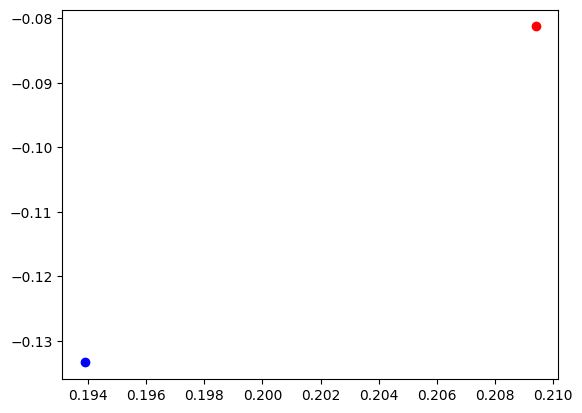

In [ ]:
from sklearn.manifold import TSNE

sc = StandardScaler()
sc.fit_transform(np.asarray( X_train_count.todense()))

pca_tsne_trunc = TruncatedSVD(2).fit_transform(X_train_tfid)
print(pca_tsne_trunc)
color_map = {"tech": "blue", "entertainment": "red"}
fig, ax = plt.subplots()
for index, instance in enumerate(pca_tsne_trunc):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = pca_tsne_trunc[index]
    color = color_map[index], 
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()


StandardScaler()

In [ ]:
sc = StandardScaler()
sc.fit(X_train_count.todense().numpy())

AttributeError: 'matrix' object has no attribute 'numpy'

In [17]:
td_idf_dense = X_train_tfid.todense()

print(td_idf_dense.shape)
print(y_train_rbf.shape)

(342, 12336)
(342,)


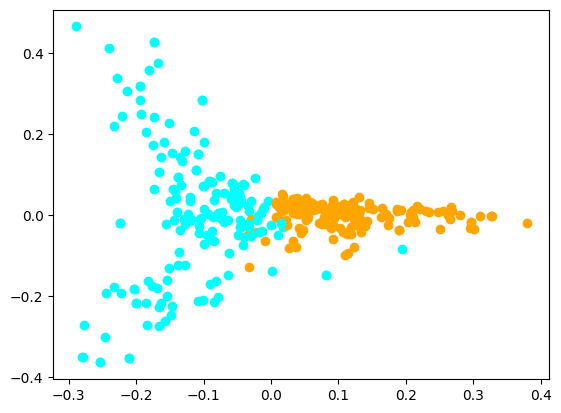

In [21]:
reduced_pca =  PCA(n_components=2)
# reduced_data = PCA(n_components=2).fit_transform(td_idf_dense)
reduced_data =reduced_pca.fit_transform(np.asarray(td_idf_dense))
# print reduced_data
labels_color_map = {"entertainment": "orange", "tech": "cyan"}
fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[y_train_rbf[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()


In [ ]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(pca, X, y, ax, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('*', 'o', 'x', '^', 'v')
    colors = ('lightblue', 'orange')
    background = ('lightcyan', 'cornsilk')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(pca.inverse_transform(
        np.array([xx1.ravel(), xx2.ravel()]).T)
        )
    Z = np.where(Z == "tech", 0, 1)
    Z = Z.reshape(xx1.shape) # Z is string
    print(Z.shape)
    
    if ax is None: ax = plt.gca()
    
    ax.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    # maybe conturf doesnt work with strings?
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label= f'class {cl}', 
                    edgecolor='k')
    

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        ax.scatter(X_test[y_test == 0, 0],
                        X_test[y_test == 0, 1],
                        c='blue',
                        edgecolor='blue',
                        alpha=1.0,
                        linewidth=1,
                        marker='+',
                        s=100, 
                        label='test set (class 1)')
        ax.scatter(X_test[y_test == 1, 0],
                        X_test[y_test == 1, 1],
                        c='red',
                        edgecolor='red',
                        alpha=1.0,
                        linewidth=1,
                        marker='+',
                        s=100, 
                        label='test set (class 2)')
        
    ax.set_xlabel('petal length [standardized]', size=16)
    ax.set_ylabel('petal width [standardized]', size=16)
    ax.legend(loc='upper left', fontsize=16)

    plt.show()

(142, 134)


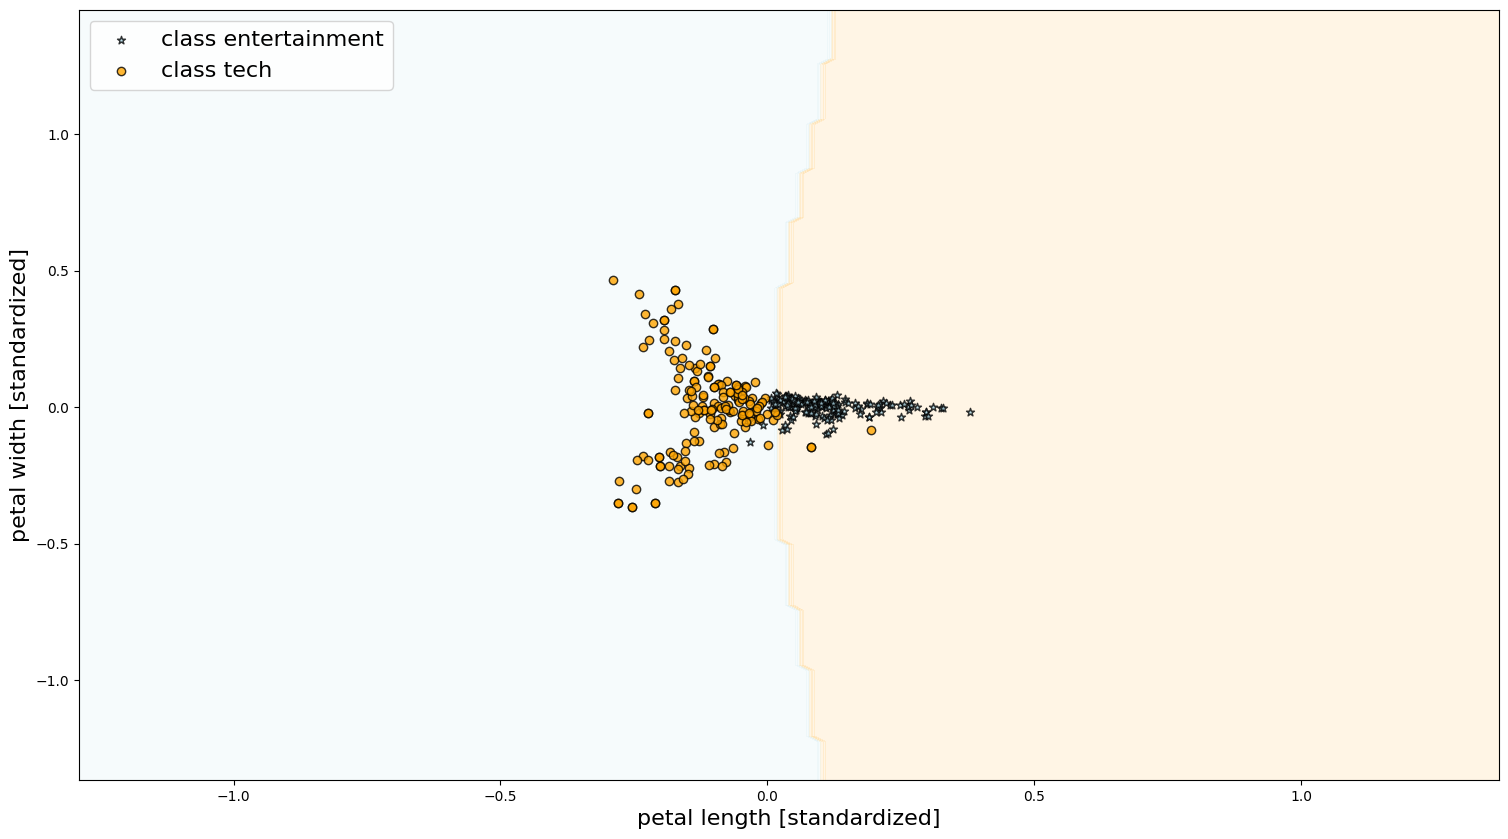

In [22]:
fig, ax_pca = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


plot_decision_regions(reduced_pca, reduced_data, y_train_rbf, ax_pca, rbf_svm, test_idx=None, resolution=0.02)





In [1]:
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay
def plot_decision_regions_2(pca, trainX, y, ax, classifier, test_idx=None, resolution=0.1):

    # setup marker generator and color map
    markers = ('*', 'o', 'x', '^', 'v')
    colors = ('lightblue', 'orange')
    background = ('lightcyan', 'cornsilk')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = trainX[:, 0].min() - 1, trainX[:, 0].max() + 1
    x2_min, x2_max = trainX[:, 1].min() - 1, trainX[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # Z = classifier.predict(pca.inverse_transform(
    #     np.array([xx1.ravel(), xx2.ravel()]).T)
    #     )
    # Z = Z.reshape(xx1.shape)
    
    if ax is None: ax = plt.gca()
    
    # ax.contourf(xx1, xx2, Z, alpha=0.1, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())


    DecisionBoundaryDisplay.from_estimator(
        estimator=classifier,
        X = pca.inverse_transform( np.array([xx1.ravel(), xx2.ravel()]).T),
        ax = ax,
        response_method="predict",
        plot_method="pcolormesh",
        alpha = 0.3,
    )
    
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label= 'class ' + str(cl+1), 
                    edgecolor='k')
    

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = trainX[test_idx, :], y[test_idx]

        ax.scatter(X_test[y_test == 0, 0],
                        X_test[y_test == 0, 1],
                        c='blue',
                        edgecolor='blue',
                        alpha=1.0,
                        linewidth=1,
                        marker='+',
                        s=100, 
                        label='test set (class 1)')
        ax.scatter(X_test[y_test == 1, 0],
                        X_test[y_test == 1, 1],
                        c='red',
                        edgecolor='red',
                        alpha=1.0,
                        linewidth=1,
                        marker='+',
                        s=100, 
                        label='test set (class 2)')
        
    ax.set_xlabel('petal length [standardized]', size=16)
    ax.set_ylabel('petal width [standardized]', size=16)
    ax.legend(loc='upper left', fontsize=16)

ValueError: n_features must be equal to 2. Got 12336 instead.

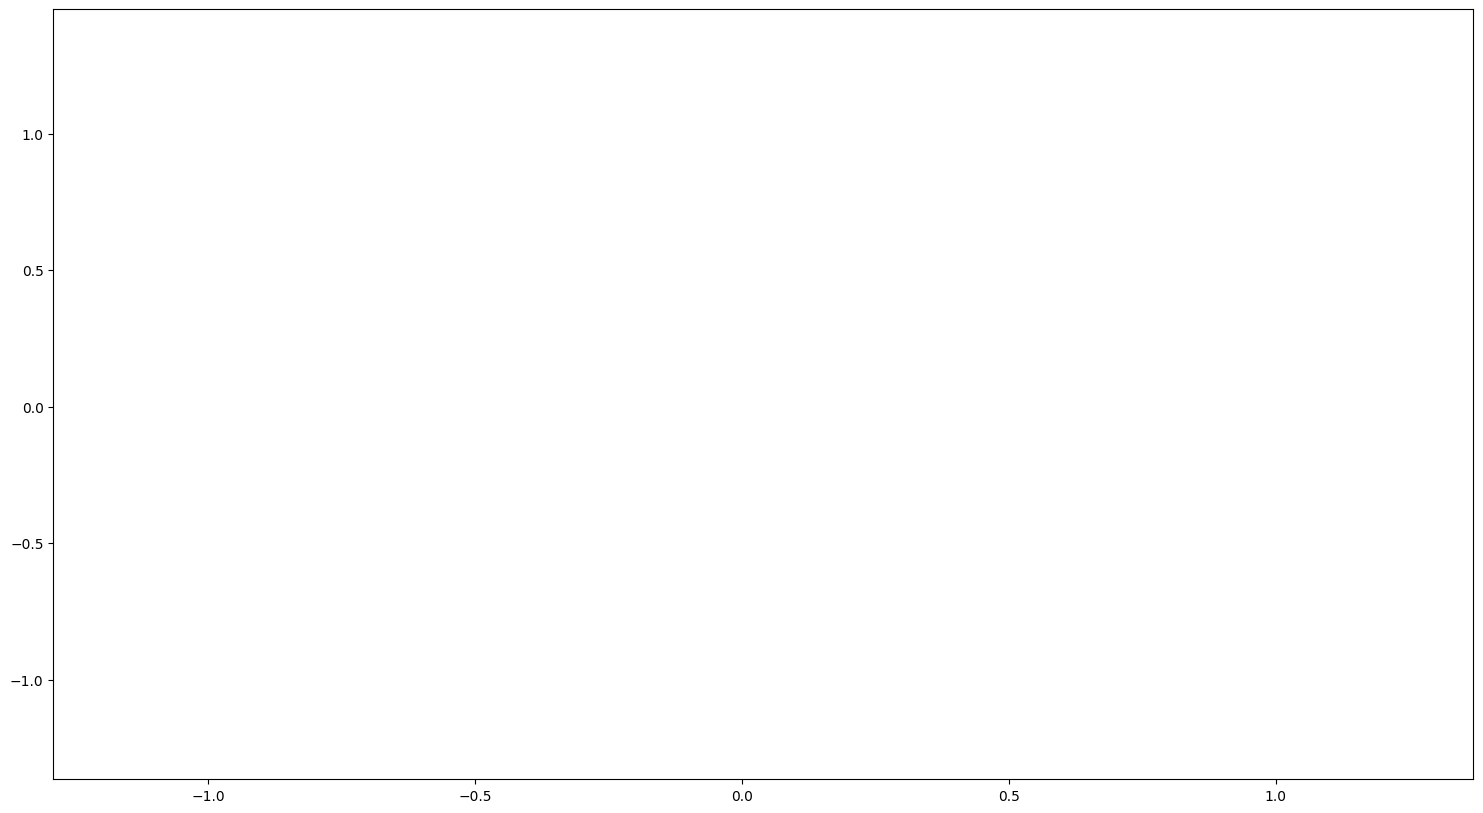

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

plot_decision_regions_2(reduced_pca, reduced_data, y_train_rbf, ax, rbf_svm, test_idx=None, resolution=0.02)

### d) Neural Network

## Task 3: Classification Quality Evaluation

(b) Let’s use 5-fold cross-validation to assess model performance. Investigate the impact of key
hyperparameters of your choices for each classifier using a testing dataset. E.g., for SVM, the
classification accuracy may be significantly affected by the kernels and hyperparameter
combination. List hyperparameters for each classifier and demonstrate how these
hyperparameters impact on the testing accuracy.


Train on train data

Predict on testing data: test once for each model




(c) Report and compare your NB, kNN, SVM and NN classifiers with the best hyperparameter
settings. Summarize what you have observed in the classification accuracy in 𝐹𝐹1 measure on
the testing dataset. 